# 📘 Fine-Tuning and Evaluating `t5-small`


## Install compatible version for Hugging Face datasets


In [1]:
!pip install fsspec==2024.12.0 --force-reinstall
!pip install -q transformers datasets evaluate sacrebleu bert-score gcsfs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_6

In [9]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
)
import evaluate

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Using device: {device}")


 Using device: cuda


In [3]:
print("📚 Loading 20% of CNN/DailyMail...")
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:20%]")


📚 Loading 20% of CNN/DailyMail...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

def preprocess_function(batch):
    inputs = tokenizer(["summarize: " + text for text in batch["article"]],
                       padding="max_length", truncation=True, max_length=512)
    targets = tokenizer(batch["highlights"],
                        padding="max_length", truncation=True, max_length=128)
    inputs["labels"] = targets["input_ids"]
    return inputs

print("🔧 Tokenizing...")
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

🔧 Tokenizing...


Map:   0%|          | 0/57423 [00:00<?, ? examples/s]

In [5]:
training_args = TrainingArguments(
    output_dir="./slm_model",
    per_device_train_batch_size=8,
    num_train_epochs=2,
    logging_steps=50,
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model)
)

print("🚀 Starting training...")
trainer.train()

print("💾 Saving fine-tuned model...")
model.save_pretrained("./slm_model")
tokenizer.save_pretrained("./slm_model")


<ipython-input-5-9cb90abecabf>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Starting training...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
50,4.105900
100,1.381600
150,1.233300
200,1.208300
250,1.120500
300,1.194200
350,1.117500
400,1.106900
450,1.124700
500,1.170100


💾 Saving fine-tuned model...


('./slm_model/tokenizer_config.json',
 './slm_model/special_tokens_map.json',
 './slm_model/spiece.model',
 './slm_model/added_tokens.json',
 './slm_model/tokenizer.json')

In [7]:
%pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=eb8a9d63ecfb07add8e00cb367195ec55fa4736f853f2150ada6a6c99b93bb6f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [8]:
print("📚 Loading validation set for evaluation...")
val_dataset = load_dataset("cnn_dailymail", "3.0.0", split="validation[:1%]")

rouge = evaluate.load("rouge")
bleu = evaluate.load("sacrebleu")
bertscore = evaluate.load("bertscore")

predictions, references = [], []
model.eval()

for item in val_dataset:
    inputs = tokenizer("summarize: " + item["article"], return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        output = model.generate(**inputs, max_length=128)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(decoded)
    references.append(item["highlights"])

rouge_result = rouge.compute(predictions=predictions, references=references)
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
bert_result = bertscore.compute(predictions=predictions, references=references, lang="en")

print("\n📊 Evaluation Metrics:")
print(f"ROUGE-1: {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"BLEU: {bleu_result['score']:.2f}")
print(f"BERTScore F1: {sum(bert_result['f1']) / len(bert_result['f1']):.4f}")


📚 Loading validation set for evaluation...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Evaluation Metrics:
ROUGE-1: 0.3111
ROUGE-2: 0.1407
ROUGE-L: 0.2396
BLEU: 12.16
BERTScore F1: 0.8684


In [10]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load pretrained LLM (flan-t5-large)
llm_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large").to(model.device)
llm_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

# Predict and evaluate with same validation set
print("🔍 Evaluating Pretrained LLM (flan-t5-large)...")
llm_predictions, llm_references = [], []

llm_model.eval()
for item in val_dataset:
    inputs = llm_tokenizer("summarize: " + item["article"], return_tensors="pt", truncation=True, padding=True, max_length=512).to(model.device)
    with torch.no_grad():
        output = llm_model.generate(**inputs, max_length=128)
    decoded = llm_tokenizer.decode(output[0], skip_special_tokens=True)
    llm_predictions.append(decoded)
    llm_references.append(item["highlights"])

# Compute scores
llm_rouge = rouge.compute(predictions=llm_predictions, references=llm_references)
llm_bleu = bleu.compute(predictions=llm_predictions, references=[[ref] for ref in llm_references])
llm_bert = bertscore.compute(predictions=llm_predictions, references=llm_references, lang="en")

# Print results
print("\n📊 LLM Evaluation Metrics:")
print(f"ROUGE-1: {llm_rouge['rouge1']:.4f}")
print(f"ROUGE-2: {llm_rouge['rouge2']:.4f}")
print(f"ROUGE-L: {llm_rouge['rougeL']:.4f}")
print(f"BLEU: {llm_bleu['score']:.2f}")
print(f"BERTScore F1: {sum(llm_bert['f1']) / len(llm_bert['f1']):.4f}")


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

🔍 Evaluating Pretrained LLM (flan-t5-large)...

📊 LLM Evaluation Metrics:
ROUGE-1: 0.2676
ROUGE-2: 0.1072
ROUGE-L: 0.2053
BLEU: 7.77
BERTScore F1: 0.8667


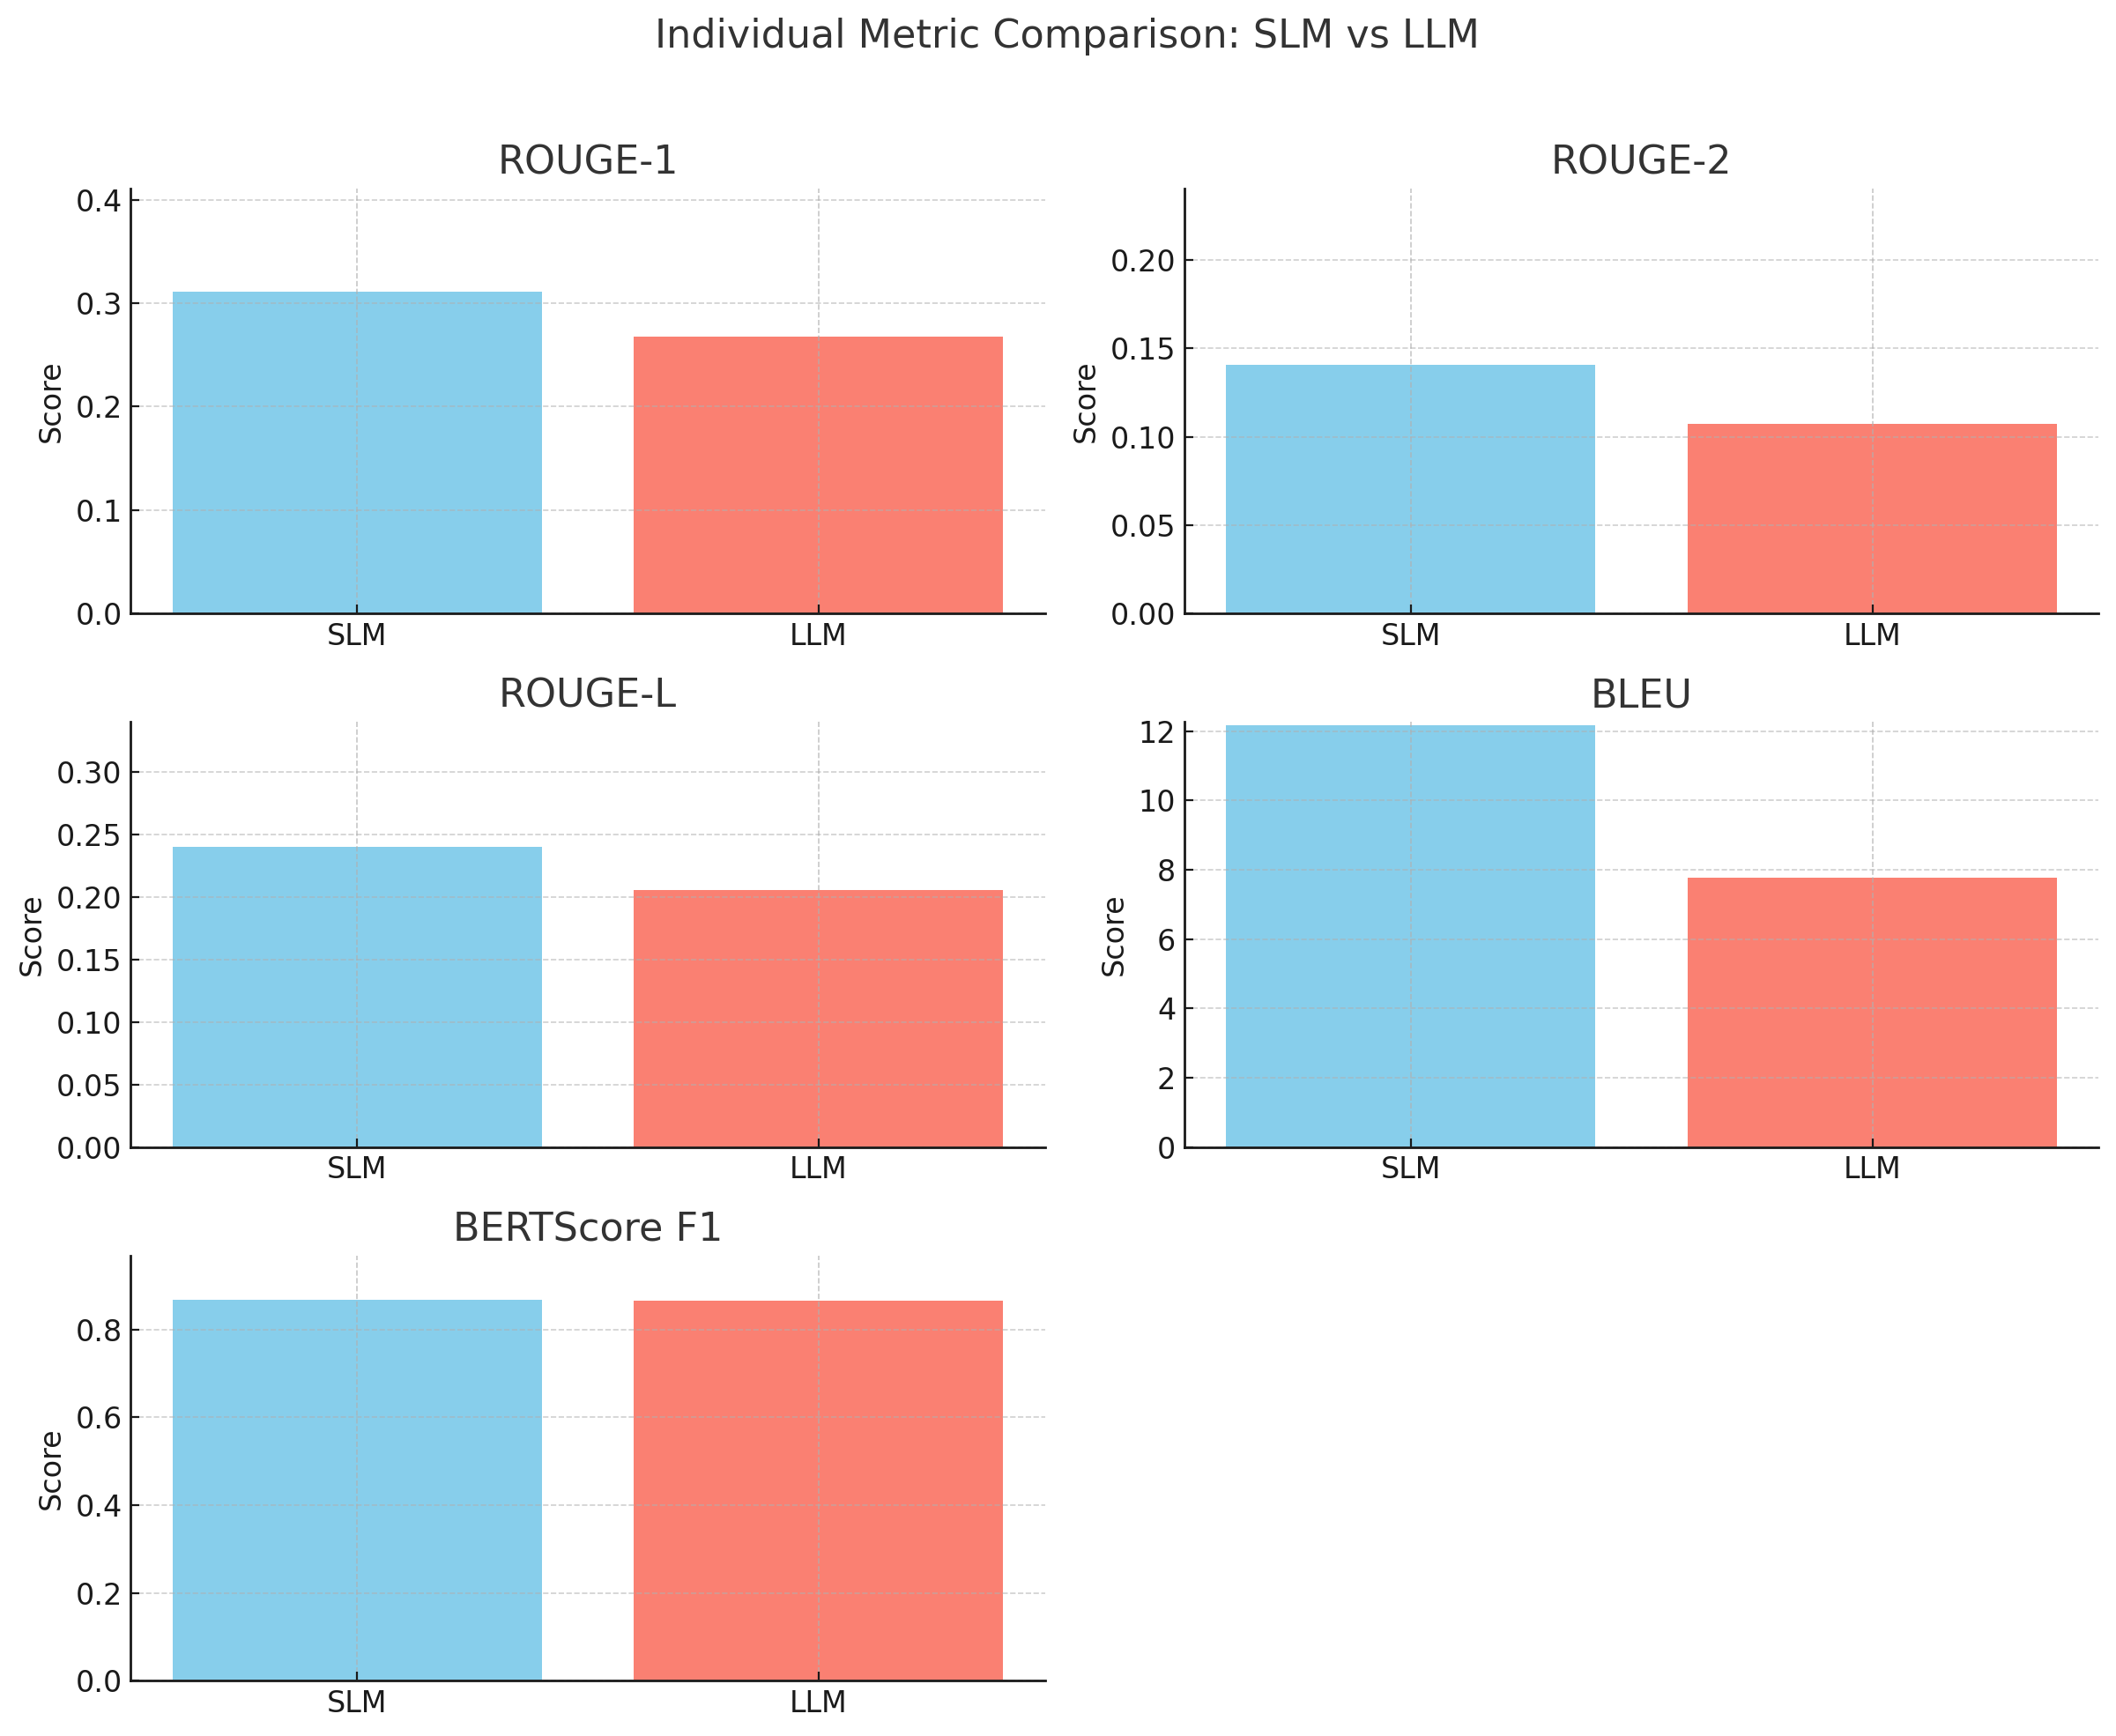